This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from cellpose import models
from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/timelapse"
    ).resolve(strict=True)
    clip_limit = 0.6

list_of_input_dirs = list(input_dir.glob("*"))
list_of_input_dirs = [x for x in list_of_input_dirs if x.is_dir()]
print(list_of_input_dirs)

figures_dir = pathlib.Path("../figures").resolve()
figures_dir.mkdir(exist_ok=True, parents=True)

[PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-05_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-03_F0001')]


In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  4600.4375


## Set up images, paths and functions

In [4]:
unique_masks_dict = {
    "diameter": [],
    "unique_masks": [],
    "image_dir": [],
}
for input_dir in tqdm.tqdm(list_of_input_dirs):
    if "2ch" not in str(input_dir):
        image_extensions = {".tif", ".tiff"}
        files = sorted(input_dir.glob("*"))
        files = [str(x) for x in files if x.suffix in image_extensions]
        image_dict = {
            "nuclei_file_paths": [],
            "nuclei": [],
        }

        # split files by channel
        for file in files:
            if "C01" in file.split("/")[-1]:
                image_dict["nuclei_file_paths"].append(file)
                image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
        nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]
        nuclei = np.array(nuclei_image_list).astype(np.int16)
        nuclei = nuclei[2, :, :]

        nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

        # model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
        model_name = "nuclei"
        model = models.Cellpose(model_type=model_name, gpu=True)

        channels = [[1, 0]]

        # get masks for all the images
        # save to a dict for later use
        img = normalize(nuclei)
        masks_all_dict = {"masks": [], "imgs": [], "diameter": []}
        for diameter in range(5, 100, 5):
            masks, flows, styles, diams = model.eval(
                img, channels=channels, diameter=diameter
            )
            masks_all_dict["masks"].append(masks)
            masks_all_dict["imgs"].append(img)
            masks_all_dict["diameter"].append(diameter)
        masks_all = masks_all_dict["masks"]
        imgs = masks_all_dict["imgs"]
        diameters = masks_all_dict["diameter"]

        masks_all = np.array(masks_all)
        imgs = np.array(imgs)
        for diameter in range(len(diameters)):

            unique_masks = np.unique(masks_all[diameter])
            unique_masks_dict["diameter"].append(diameters[diameter])
            unique_masks_dict["unique_masks"].append(len(unique_masks))
            unique_masks_dict["image_dir"].append(input_dir.name)

100%|██████████| 4/4 [01:54<00:00, 28.69s/it]


In [5]:
all_masks_df = pd.DataFrame(unique_masks_dict)
all_masks_df.head()

,diameter,unique_masks,image_dir
0,5,939,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
1,10,774,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
2,15,201,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
3,20,170,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
4,25,181,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001


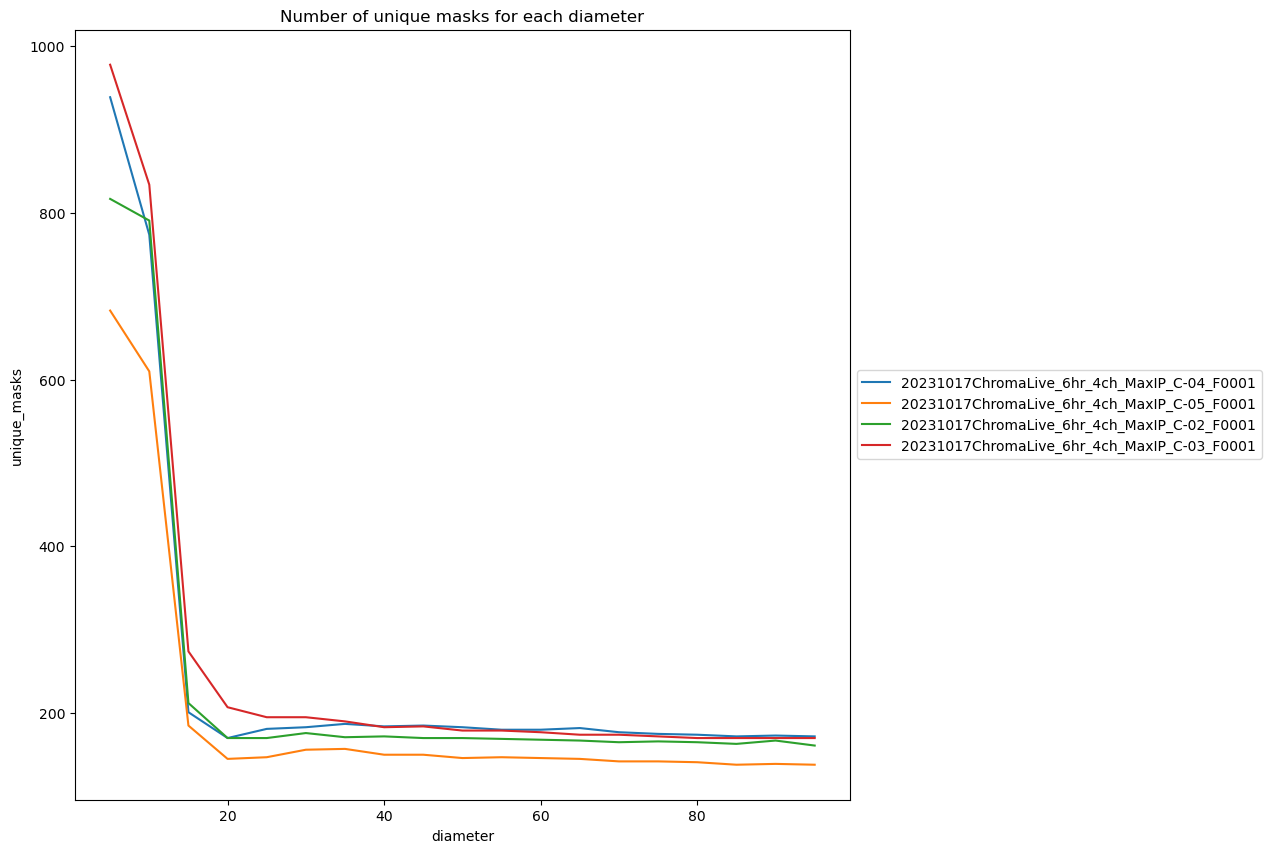

In [6]:
# plot the nuumber of masks for each diameter
plt.figure(figsize=(10, 10))
# plt.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")
sns.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")
# move the legend outside the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Number of unique masks for each diameter")
plt.show()